In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.datasets import load_boston, load_iris, load_breast_cancer

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score, mean_squared_error


from IPython.core.display import display, HTML

In [2]:
from Utils import prepareData, plot2Dimensions, plot_Kneighbors, my_final_plot_comparison, plot_decision_boundary_k

# **Cronograma e Requisitos**

**Cronograma:**

- Classificação $\mathbb{R}^2$:
  1. Entender a intuição do algoritmo.
  2. Implementar o algoritmo de **KNN** para classificação.
  3. Utilizar o algoritmo **KNeighborsClassifier** do Sklearn para nos apronfundar no algoritmo.
  
---
- Regressão $\mathbb{R}^n$:
    4. Exemplificar KNN para regressão.
    
---
- Extra:
    5. Retomar alguns pontos importantes.
    6. Próximos passos.
    
---
**Requisitos** 

Necessários:

1. Dominar python e pandas.
2. Nomenclatura e conceitos básicos de aprendizagem.
    - labels (targets).
    - features (variáveis).
    - exemplos de test, treino.
    - normalização de dados.

Desejáveis:

3. Entender conceitos de aprendizado de máquina:
    - Regressão $vs$ Classificação.
    - *trade off* bias-variance (viés-variância).
    - Overfitting $vs$ Underfitting.
    - Cross-validation.

# **Loading**

In [3]:
#Data Frame para classificação
iris_df, description_clas = prepareData(load_iris)
cancer_df, description_clas = prepareData(load_breast_cancer)
#Select your data-set
df = iris_df
#Data Frame para regressão
df_regr, description_regr = prepareData(load_boston)

# **K-nearest neighbors**

## **Um pouco de teoria**

***Pontos Gerais:***

- Usado para problemas de **classificação** e **regressão**.

- Usado normalmente como benchmark para algoritmos mais complexos, isto é, antes de rodar o algoritmo mais complexo você roda o KNN.

- Usado normalmente como benchmark para algoritmos mais complexos.

- Possuí bons resultados em diversas áreas como econometria, compressão de dados e genética.


***Sobre o Algoritmo:***

- É um algoritmo supervisionado, isto é, precisamos de labels.

- Cada exemplo é representado por um vetor no $\mathbb{R}^n$ e seu label.

- O algoritmo pode ser resumido em dois passos:
  - Calcula a **distância** do *exemplo test* para todos os exemplos do dataset.
  
  - Seleciona os $K$ vizinhos mais próximos e calcula o resultado.


***Detalhes do Algoritmo:***

- É uma técnica não paramétrica, isto é, a gente não assume nenhuma distribuição para treinar o algoritmo.

- **Não** possui uma fase explícita de treinamento (lazy).


## **Intuição do algoritmo** 

Quantas features existem no nosso dataset?

In [4]:
features = df.columns.tolist()[:-1]
print(f"Temos {len(features)} features: {features}\n")

Temos 4 features: ['feature_1', 'feature_2', 'feature_3', 'feature_4']



Visando simplificar o entendimento vamos aprensentar o algoritmo em duas dimensões.

In [5]:
#sns.pairplot(df.iloc[:,-5:], hue = "target")

In [6]:
X_Features = df.filter(regex = "feature") # Dataframe que contém todas as features
X_2D       = X_Features.iloc[:,[0,1]]        # Dataframe que contém as duas primeiras features
y          = df.filter(regex = "target")  # Dataframe que contém os nossos labels (targets)

### **Visualizando as duas dimensẽos**

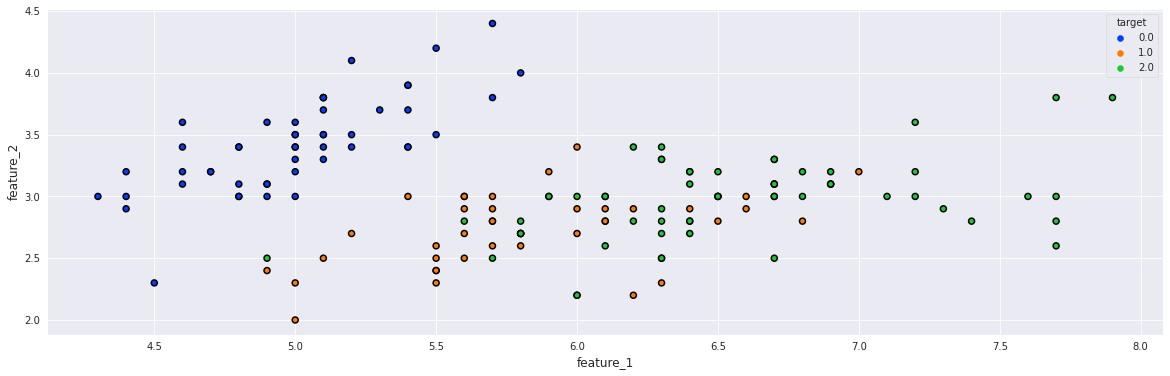

In [7]:
fst_dim = X_2D.iloc[:,0].name # String referente a feature da primeira dimensão
snd_dim = X_2D.iloc[:,1].name # String referente a feature da segunda dimensão

#Vamos ver como os dados estão distribuídos utilizando essas duas dimensões.
_=plt.figure(figsize=(20,6))
_=sns.scatterplot(data = df, x=fst_dim, y=snd_dim, hue="target", palette="bright", edgecolor="black", linewidth=1.5)
plt.show()

### **Visualizando a posição de exemplos teste**

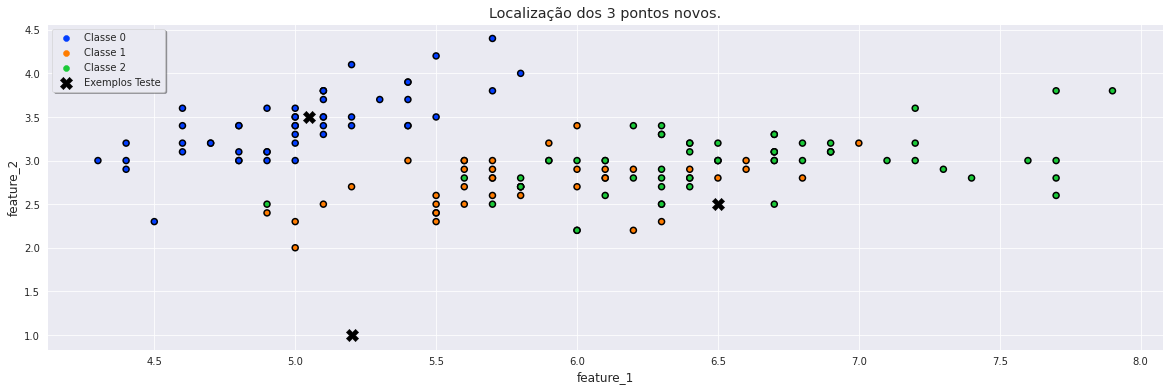

In [8]:
#Pontos test, coloque quantos quiser!! - (x,y)
test_examples = np.array([[5.05, 3.5],
                          [6.5, 2.5],
                          [5.2, 1],])

plot2Dimensions(df, fst_dim, snd_dim, test_examples)

## **Implementação do algoritmo**

Precisamos de uma forma de medir a distância entre dois pontos, isto é, precisamos de uma métrica de distância:

-  Distância de Minkowski:
$$D(X,Y) = (\sum_{i=1}^{n} |x_i - y_i|^p)^{\frac{1}{p}}$$

-  Distância Euclidiana ($p=2$):

$$D(X,Y) = (\sum_{i=1}^{n} |x_i - y_i|^2)^{\frac{1}{2}} = \sqrt{\sum_{i=1}^{n} |x_i - y_i|^2}$$
  
Obs: Como estamos trabalhando com distâncias, caso a escala das variáveis seja muito diferente é importante realizar **normalização** das features (variáveis)!!!

In [9]:
examples_distance_data = euclidean_distances(X_2D, test_examples)
columns = [f"distance-point-{col+1}" for col in range(examples_distance_data.shape[1])]
examples_distance_df = pd.DataFrame(data=examples_distance_data, columns=columns)

In [10]:
examples_distance_df.head(2)

,distance-point-1,distance-point-2,distance-point-3
0,0.050000,1.720465,2.501999
1,0.522015,1.676305,2.022375


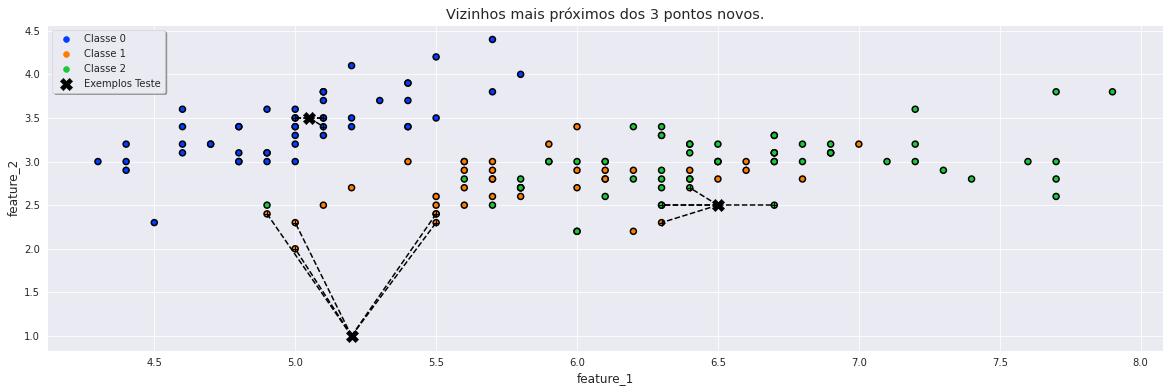

In [11]:
df_distance_class = pd.concat([X_2D, y, examples_distance_df], axis = 1)
plot_Kneighbors(df_distance_class, fst_dim, snd_dim, test_examples, figsize=((20,6)), k_neighbors=5)

In [12]:
k = 5
example_test = "distance-point-1"
df_distance_class.nsmallest(k, example_test).filter(regex=f"feature|target")

,feature_1,feature_2,target
40,5.0,3.5,0.0
43,5.0,3.5,0.0
0,5.1,3.5,0.0
17,5.1,3.5,0.0
39,5.1,3.4,0.0


In [13]:
"""
 - value_counts(normalize=True) : Realiza o voto majoritario:

 - idxmax() : Seleciona a classe com maior voto.
"""

for col in df_distance_class.filter(regex = "distance"):
    print(f"Checando exemplo teste: {col.split('-')[1]}")
    examplo_classe = df_distance_class.nsmallest(k, col)["target"].value_counts(normalize=True).idxmax()
    print(examplo_classe)

Checando exemplo teste: point
0.0
Checando exemplo teste: point
2.0
Checando exemplo teste: point
1.0


## **Sklearn - KNeighborsClassifier**

In [14]:
#Separando os dados ... 
X_train, X_test, y_train, y_test = train_test_split(X_2D, y, test_size=0.1, random_state=42)

In [15]:
knn = KNeighborsClassifier(n_neighbors = 5,
                           weights     = "uniform",   #Devo utilizar a distância para pesar o output?
                           algorithm   = "auto",      #Algoritmo usado para encontrar os vizinhos mais próximos
                           n_jobs      = 1,           #Número de processos para encontrar os vizinhos mais próximos
                           metric      = "minkowski", #Métrica de distância
                           p           = 2,           #Distância Euclidiana
                          )

### **Procedimento Usual** 

In [16]:
def my_pipeline(X_train, X_test, y_train, y_test, model):

    #Treina o modelo
    model.fit(X_train, y_train.target.values)
    
    #Prevê o valor utilizando os exemplos de teste
    y_hat = pd.Series(model.predict(X_test), name="target")
    
    #Monta datasets para visualização dos dados
    test_df = pd.concat([X_test.reset_index(drop=True), y_hat], axis=1)
    train_df = pd.concat([X_train, y_train], axis=1)
    
    return test_df, train_df

knnSklearn_df, train_df = my_pipeline(X_train, X_test, y_train, y_test, knn)

In [17]:
final_data = pd.concat([train_df.assign(tipo="Treino"),knnSklearn_df.assign(tipo="Test")])

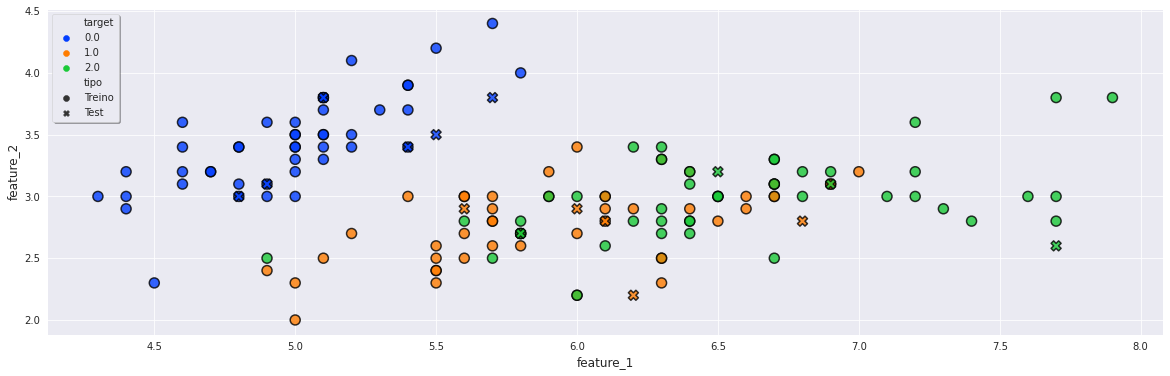

In [18]:
my_final_plot_comparison(final_data, fst_dim, snd_dim)

### **E se $K$ for igual ao número de exemplos no Treino?** 

In [19]:
knn = KNeighborsClassifier(n_neighbors = X_train.shape[0],
                           weights   = "uniform", 
                           algorithm = "auto",      #Algoritmo usado para encontrar os vizinhos mais próximos
                           n_jobs    = 1,           #Número de processos para encontrar os vizinhos mais próximos
                           metric    = "minkowski", #Métrica de distância
                           p         = 2,           #Distância Euclidiana
                          )

In [20]:
knnSklearn_df, train_df = my_pipeline(X_train, X_test, y_train, y_test, knn)
final_data = pd.concat([train_df.assign(tipo="Treino"),knnSklearn_df.assign(tipo="Test")])

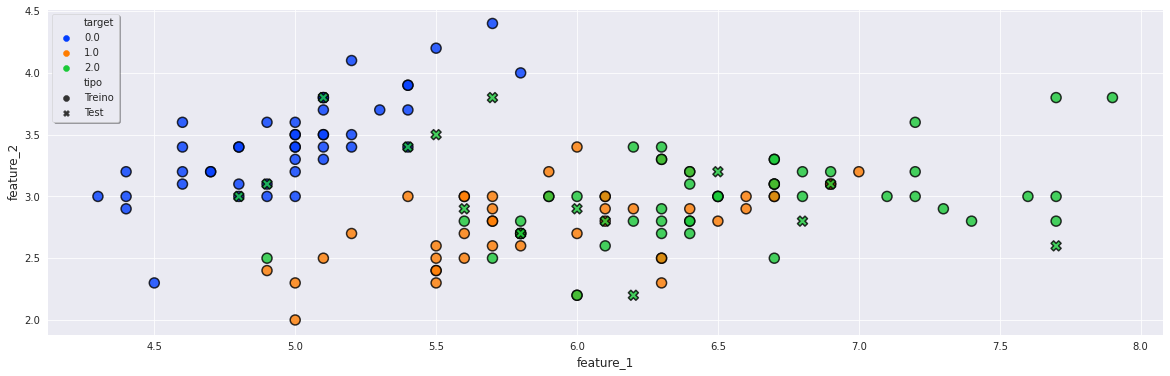

In [21]:
my_final_plot_comparison(final_data, fst_dim, snd_dim)

In [22]:
#Realiza o voto majoritário referente ao dataset de treino
y_train["target"].value_counts(normalize=True).idxmax()

2.0

Resumindo, não estou levando as features em consideração, estamos prevendo utilizando simplesmente a probabilidade a priori.

### **Como selecionar o K correto ?** 

Função para plot de fronteira de decisão baseado no seguinte site:

https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

#### **Como o k influencia na fronteira de decisão?**

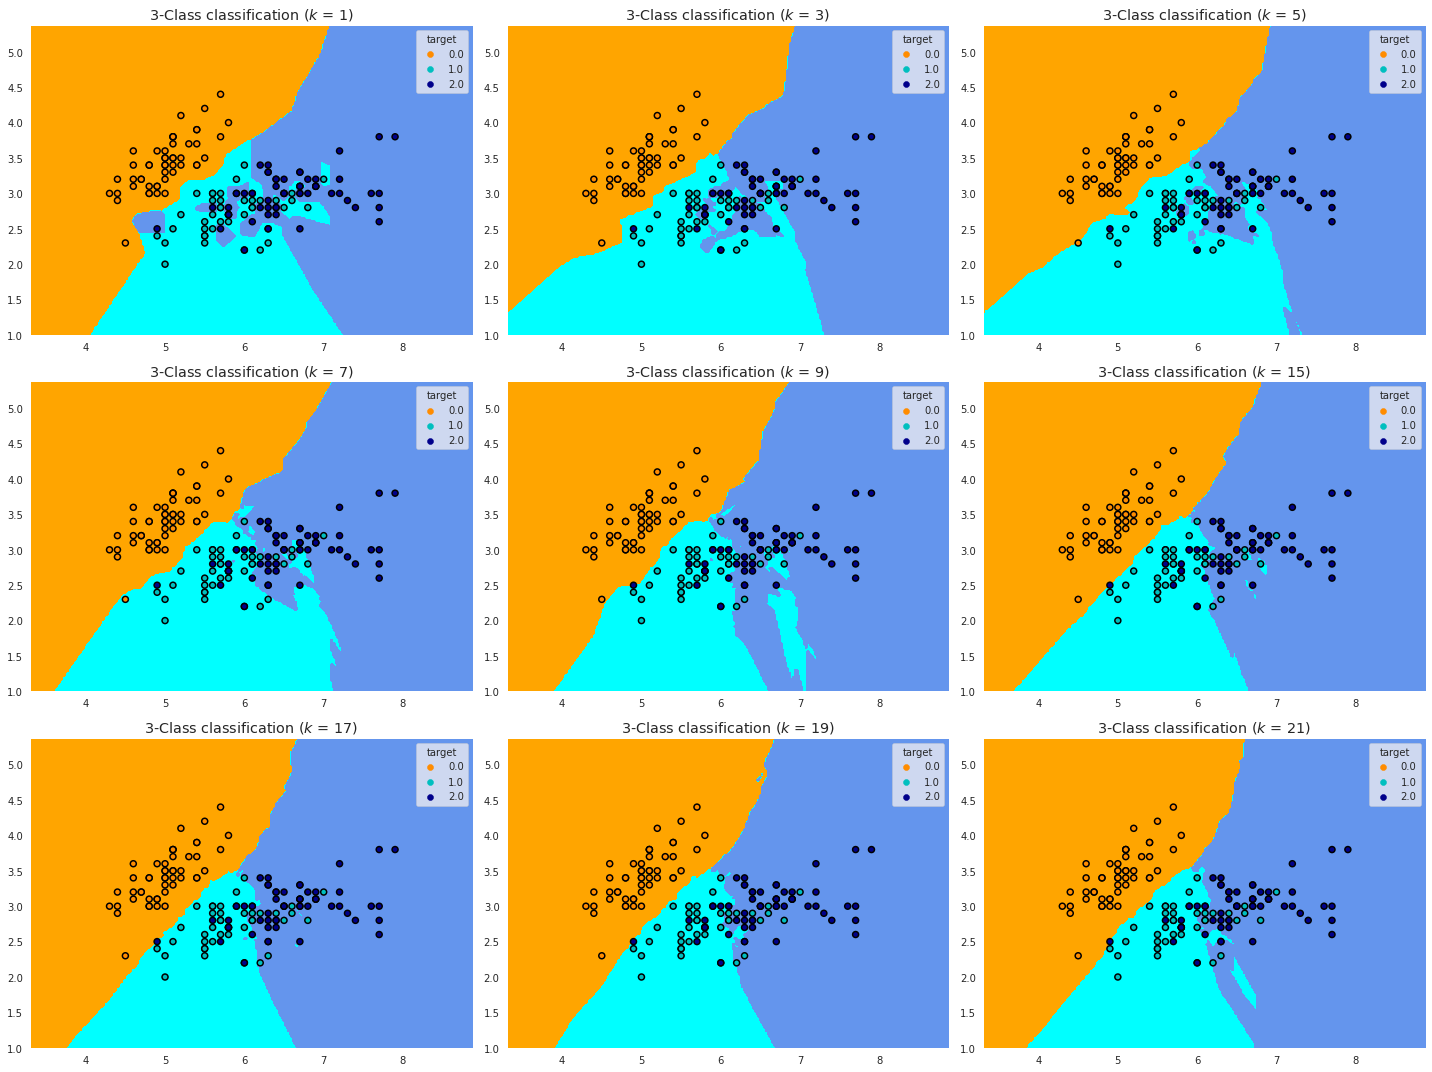

In [23]:
#Selecionar um número de valor k multiplos de 3, caso contrario alguns valores de k não serão utilizados.
n_neighbors_lst = [1,3,5,7,9,15,17,19,21]
    
plot_decision_boundary_k(X_2D, y, n_neighbors_lst)

- Maior: $K \rightarrow $ underfitting
- Menor: $K \rightarrow $ overfitting.

#### **Cross Validation**

<details><summary><b>Open</b></summary>
<img style="width: 400px;" src="figures/cross_val.png">
    
https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

In [24]:
def find_best_k(X, y, fold_method, model, metric, neighbors):
    
    skf = fold_method(n_splits=10)

    mean_train_scores = []
    mean_test_scores  = []

    cv_train_scores   = []
    cv_test_scores    = []

    for k in neighbors:
        for train_index, test_index in skf.split(X, y):
            X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
            y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

            #Instância o classificador.
            knn = model(n_neighbors=k)
            #Treina com os dados de treino.
            knn.fit(X_train_fold, y_train_fold.target)

            #Testa com os dados que não foram vistos (teste)
            y_test_hat = knn.predict(X_test_fold)
            cv_test_scores.append(metric(y_test_fold, y_test_hat))

            y_train_hat = knn.predict(X_train_fold)
            cv_train_scores.append(metric(y_train_fold, y_train_hat))

        mean_train_scores.append(np.mean(cv_train_scores))
        mean_test_scores.append(np.mean(cv_test_scores))
        
    return mean_train_scores, mean_test_scores, neighbors

mean_train_scores, mean_test_scores, neighbors = find_best_k(X_train, 
                                                             y_train, 
                                                             StratifiedKFold,
                                                             KNeighborsClassifier,
                                                             accuracy_score, 
                                                             list(range(1, 80, 2)))

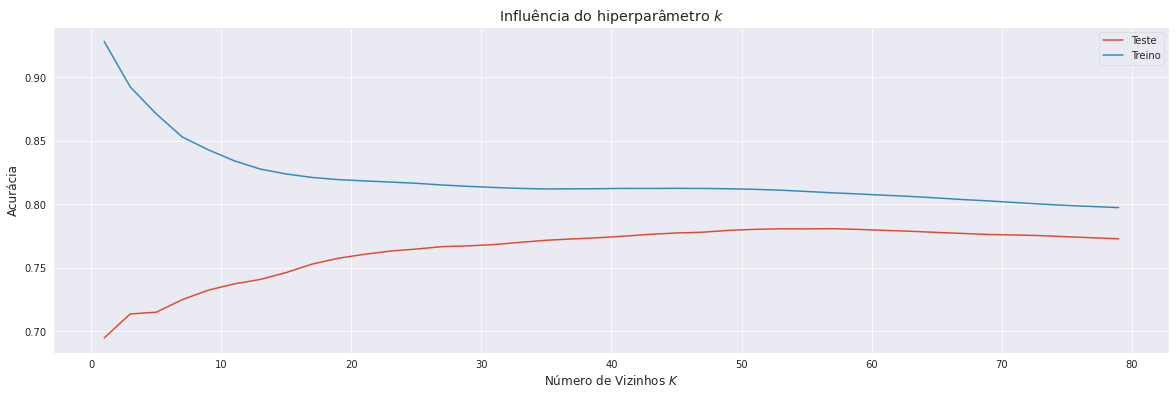

In [25]:
plt.figure(figsize=(20,6))
plt.plot(neighbors, mean_test_scores,   label = "Teste")
plt.plot(neighbors, mean_train_scores,  label = "Treino")

plt.xlabel("Número de Vizinhos $K$")
plt.ylabel("Acurácia")
plt.title("Influência do hiperparâmetro $k$")

plt.legend()
plt.show()

## **Regressão**

In [26]:
X = df_regr.filter(regex="feature")
y = df_regr.filter(regex="target")

### **Procedimento Padrão**

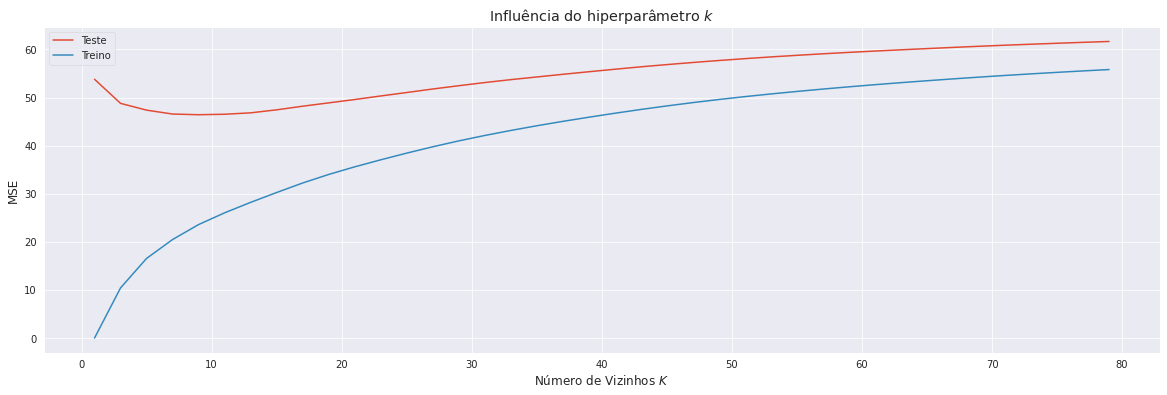

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mean_train_scores, mean_test_scores, neighbors = find_best_k(X_train, 
                                                             y_train, 
                                                             KFold,
                                                             KNeighborsRegressor,
                                                             mean_squared_error, 
                                                             list(range(1, 80, 2)))

plt.figure(figsize=(20,6))
plt.plot(neighbors, mean_test_scores,   label = "Teste")
plt.plot(neighbors, mean_train_scores,  label = "Treino")

plt.xlabel("Número de Vizinhos $K$")
plt.ylabel("MSE")
plt.title("Influência do hiperparâmetro $k$")

plt.legend()
plt.show()

### **Será que a gente consegue fazer melhor?**

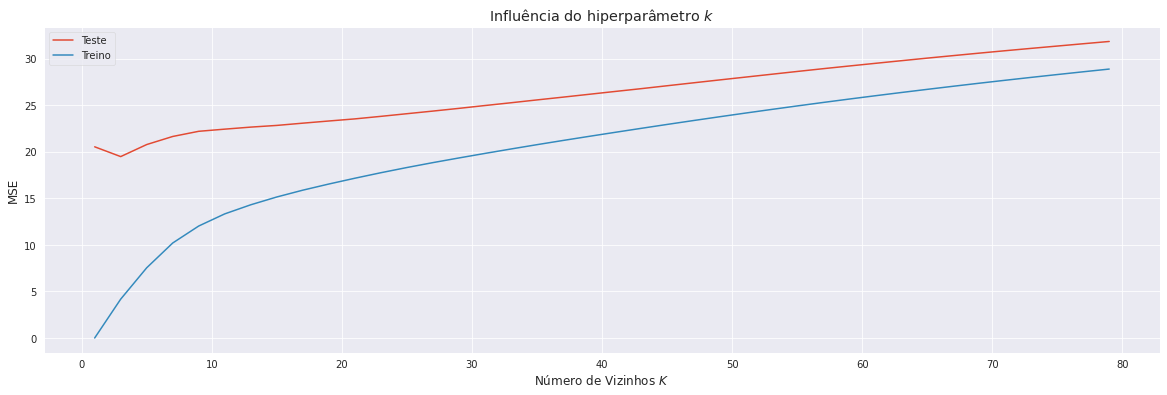

In [28]:
X_norm = pd.DataFrame(StandardScaler().fit_transform(X))

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)


mean_train_scores, mean_test_scores, neighbors = find_best_k(X_train, 
                                                             y_train, 
                                                             KFold,
                                                             KNeighborsRegressor,
                                                             mean_squared_error, 
                                                             list(range(1, 80, 2)))

plt.figure(figsize=(20,6))
plt.plot(neighbors, mean_test_scores,   label = "Teste")
plt.plot(neighbors, mean_train_scores,  label = "Treino")

plt.xlabel("Número de Vizinhos $K$")
plt.ylabel("MSE")
plt.title("Influência do hiperparâmetro $k$")

plt.legend()
plt.show()

## **Extra**

Pontos Importantes para se lembrar:

- Como não tem uma fase de treinamento é útil para testar um dataset e assim ter um benchmark inicial.

- Pode ser usado tanto para regressão (***KNeighborsRegressor***) quanto classificação (***KNeighborsClassifier***). **Não esquecer de utilizar a métrica correta para avaliar o modelo.**

- Quanto menor o valor de k mais provável é que seu modelo está overfitando os dados. Utilizar cross validation para escolher o melhor K.

- Se os dados tem escalas diferentes normalização pode melhorar a performance do seu modelo.

Próximos passos:

- Como técnicas de redução dimensional podem melhorar os resultados?

- Qual a métrica de distância correta a ser utilizada?

- Quais são os algoritmos utilizados para calcular os $K$ vizinhos mais próximos?